In [1]:
! pip install pywph==1.0

Reason for being yanked: Wrong requirements.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pywph as pw
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import time
import scipy.optimize as opt

In [3]:
# importing files from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
nbody = np.load('drive/MyDrive/camels data/Maps_Mtot_Nbody_SIMBA_LH_z=0.00.npy')

(256, 256)
(256, 256)


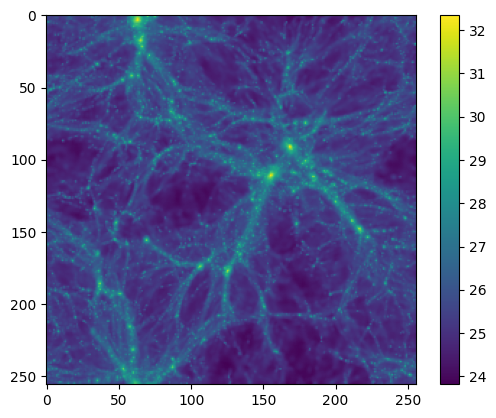

In [6]:
nbody = np.copy(nbody[0])
data = np.log(nbody)
print(nbody.shape)
print(data.shape)

plt.imshow(data)
plt.colorbar()


In [7]:
M = 256
N = 256
J = 7
L = 4
dn =0

wph_op = pw.WPHOp(M, N, J, L=L, dn=dn) # operator
coeff = wph_op(data) # get coefficients


In [8]:
print(coeff.shape)

torch.Size([520])


In [9]:
# run on a GPU device
if torch.cuda.is_available():
    wph_op.to(0)

In [10]:
wph = wph_op(data, ret_wph_obj=True) # WPH object
print(wph)
# easier to get coefficients


In [11]:
# obtain coefficients and their corresponding indices
s11, s11_in = wph.get_coeffs("S11")
s00, s00_in = wph.get_coeffs("S00")
s01, s01_in = wph.get_coeffs("S01")
c01, c01_in = wph.get_coeffs("C01")
cphase,cphase_in = wph.get_coeffs("Cphase")

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


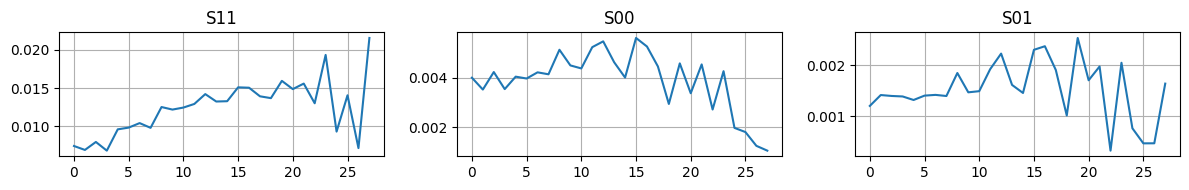

In [12]:
# s coefficients
fig, axs = plt.subplots(1, 3, figsize=(12, 2))

axs[0].plot(s11)
axs[1].plot(s00)
axs[2].plot(s01)

axs[0].set_title('S11')
axs[1].set_title('S00')
axs[2].set_title('S01')
axs[0].grid()
axs[1].grid()
axs[2].grid()

fig.tight_layout()
fig.show()

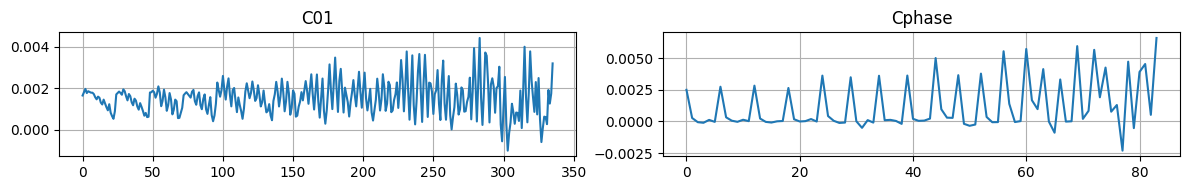

In [13]:
# c coefficients
fig, axs = plt.subplots(1, 2, figsize=(12, 2))
axs[0].plot(c01)
axs[1].plot(cphase)

axs[0].set_title('C01')
axs[1].set_title('Cphase')
axs[0].grid()
axs[1].grid()

fig.tight_layout()
fig.show()

In [14]:
# generate a noise image as an initial guess
guess = np.random.normal(data.mean(), data.std(), data.shape)

coeff = wph_op(data,norm='auto') # normalise data coefficients
print(coeff.shape)

torch.Size([520])


In [15]:
# optimizer

count = 0

def objective(y):
    global count
    print(f"Evaluation: {count}")
    start_time = time.time()
    loss_tot = torch.zeros(1)

    Y = y.reshape((M, N)) # reshape y

    # calculate loss
    Y, chunks = wph_op.preconfigure(Y, requires_grad=True)
    for i in range(chunks):
        y_coeffs_chunk, indices = wph_op(Y, i, norm='auto', ret_indices=True) # get coefficients and indice
        loss = torch.sum(torch.abs(y_coeffs_chunk - coeff[indices])** 2) # compute residual
        loss.backward(retain_graph=True)
        loss_tot += loss.detach().cpu()
        del y_coeffs_chunk, indices, loss

    y_final = Y.grad.cpu().numpy().astype(y.dtype) # reshape gradient
    print(f"Loss: {loss_tot.item()} (computed in {(time.time() - start_time):.2f}s)")
    count += 1
    return loss_tot.item(), y_final.ravel()

In [ ]:
# run optimizer
# max number of iterations: 80
result = opt.minimize(objective, guess.ravel(), method='L-BFGS-B', jac=True, tol=None, options={"maxiter": 50, "gtol": 1e-14, "ftol": 1e-14, "maxcor": 20})
final_loss, final_guess, niter, msg = result['fun'], result['x'], result['nit'], result['message']
final_guess = final_guess.reshape(guess.shape)
print(f"Synthesis ended in {niter} iterations with optimizer message: {msg}")

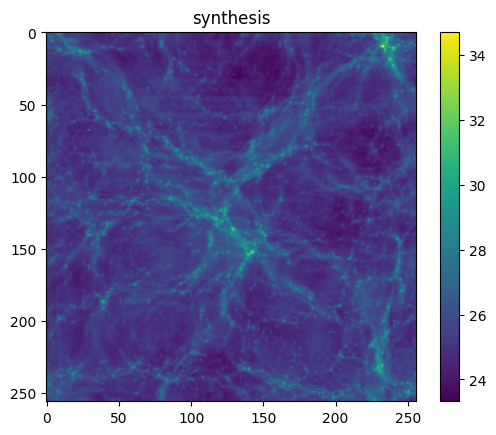

In [22]:
plt.imshow(final_guess)
plt.title('synthesis')
plt.colorbar()

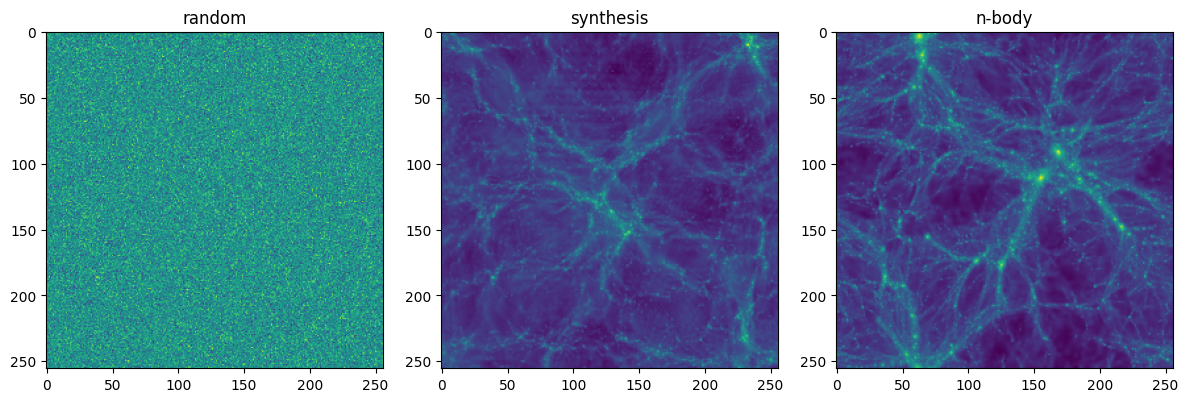

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(12, 12))

axs[0].imshow(guess)
axs[1].imshow(final_guess)
axs[2].imshow(data)

axs[0].set_title('random')
axs[1].set_title('synthesis')
axs[2].set_title('n-body')

fig.tight_layout()
fig.show()

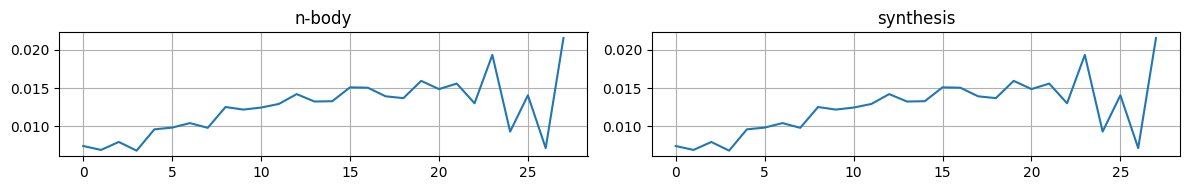

In [20]:
# compare s11 coefficients

wph1 = wph_op(final_guess, ret_wph_obj=True) # WPH object
s11_guess, s11_in_guess = wph.get_coeffs("S11")

fig, axs = plt.subplots(1, 2, figsize=(12, 2))
axs[0].plot(s11)
axs[1].plot(s11_guess)
axs[0].set_title('n-body')
axs[1].set_title('synthesis')
axs[0].grid()
axs[1].grid()

fig.tight_layout()
fig.show()


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


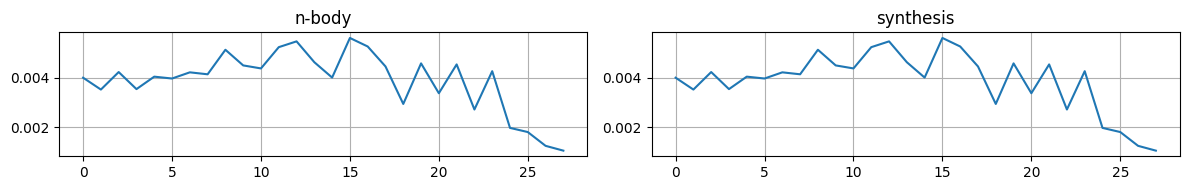

In [24]:
# compare s10 coefficients

wph1 = wph_op(final_guess, ret_wph_obj=True) # WPH object
s00_guess, s00_in_guess = wph.get_coeffs("S00")

fig, axs = plt.subplots(1, 2, figsize=(12, 2))
axs[0].plot(s00)
axs[1].plot(s00_guess)
axs[0].set_title('n-body')
axs[1].set_title('synthesis')
axs[0].grid()
axs[1].grid()

fig.tight_layout()
fig.show()
